# AnomalyToolKit: Typicality check - Real-time mode application

This text explains how to use the typicality checks in the AnomalyToolKit for real-time application to a univariate sensor signal.

# Loading modules

Loading the modules we need throughout the notebook and fine-tuning the browser display:

In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:2500px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
import numpy 
import pandas
import os
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append('..')

# Loading data

As an example, we use data from a sensor ageing data repository.  (v1.0.2) [[Zenodo]](https://doi.org/10.5281/zenodo.3229195). Make sure you have downloaded the file  `potential_rowB.zip`, unzip the contents into a folder of your liking. Then, make sure the folder path in the following cell matches the folder you have chosen:

In [3]:
strFolder = 'C:/G/data/sensorageing/potential_rowB/'

To enable use of the productivity check, we load all data in a string format. This avoids automatic conversions which may mask some issues with the data.

In [4]:
filename  = Path(strFolder+'rowB_potential_day332.csv')
dfStrData = pandas.read_csv(filepath_or_buffer=filename,delimiter  =';',header =0,dtype=str)
dfStrData.head()

date_time         T1b         T2b         T3b         T4b  \
0  2017.08.31 00:00:01   30.400000    2.700000   -9.300000   48.599998   
1  2017.08.31 00:00:02   30.300001    2.700000   -9.300000   48.599998   
2  2017.08.31 00:00:03   30.400000    2.600000   -9.400000   48.599998   
3  2017.08.31 00:00:04   30.400000    2.700000   -9.400000   48.599998   
4  2017.08.31 00:00:05   30.300001    2.700000   -9.300000   48.599998   

  Unnamed: 5  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

# DateTimeCheck + NumericCheck + TypicalityCheck: Setup and testing

We set up an one instance of the class *datetimecheck* in the *production* module and call it *dtcheck*. We define it so that the expected datetime format matches the *date_time* variable in the first 5 lines shown above. We also set up a check to test if the sensor readings can be interpreted as numeric values. The checks are instances of the class *numericcheck* in the same module (*production*). Finally, we add a *typicalitycheck* from the *typical* module and called *typcheck*. This check evaluate the degree to which the numeric value is typical relative to the historical data To do this, we require the specification of the accepted measurement range, we set it here to +/- 420 mV. In this case, this roughly corresponds to (theoretical) pH values from 0 to 14.

In [5]:
from basic.production import datetimecheck
from basic.typical import typicalitycheck
from basic.production import numericcheck

CheckDT  = datetimecheck(DateTimeFormat='%Y.%m.%d %H:%M:%S')
CheckNUM = numericcheck(NumberFormat='float')
CheckTYP = typicalitycheck(MinimumFeasibleValue=-420,MaximumFeasibleValue=+420)

Now test *dtcheck* on the first data point in the data frame and print the two outputs, which are the result of the check and the datetime string converted to a numpy datetime64 object. Then, we check whether the sensor reading is a number. The number is then entered to compute the typicality score.  Note that each data entry must be passed as a list (use of outer square brackets: `DateTimeEntry=[dt1]`) for all checks.

In [6]:
dt0 = dfStrData['date_time'][0]
CheckResult , DateTime =CheckDT(DateTimeEntry=[dt0])
print('Result of check: '+str(CheckResult))
print(DateTime)
CheckResult , Number =CheckNUM(NumberEntry=[dfStrData['T4b'][0]])
print('Result of check: '+str(CheckResult))
Score,Density = CheckTYP([Number])
print('Score: '+str(Score))
             

Result of check: [True]
[numpy.datetime64('2017-08-31T00:00:01.000000')]
Result of check: [True]
Score: [0.]


The computed score equals the minimum value of zero because no previous sensor reading was equal to the checked sensor reading. This is simply because this is first sensor reading. If we evaluate the same reading again, we get the maximal score (7). This is because all previous values are equal to the tested sensor reading:

In [7]:
Score,Density = CheckTYP([Number])
print('Score: '+str(Score))

Score: [7.]


If the checked reading is not a number (NaN), it will be ignored for density model updating and will receive a zero typicality score:

In [8]:
Score = CheckTYP([numpy.nan])
print('Score: '+str(Score))

Score: (array([0.]), array([0.]))


# Emulating an online application

Obviously, the data used in this demo is historical data. To emulate an online application, we will use a for loop which runs over all the data points from first to last. The for loop below checks every datetime and every sensor reading in a sequential manner, as one would expect in an online application. The code snippet that would be used in a real-time case is indicated in the comments. We also produce a figure with four panels by means of `typdisp`, which is an instance of the `typicalitydisplay` class. The panels are updated every time 300 measurements are processed (about 5 minutes of signal data). The top-left panel contains the last 3600 values with a colour-coded indication of the typicality score. The bottom-left panel displays the typicality score with a matching colouring. On the top-right, one can see the density model. The bottom-right panel shows the typicality score against the density of the last 3600 points. When these points form a line, it means the density model is not changing much at this time. 

<IPython.core.display.Javascript object>


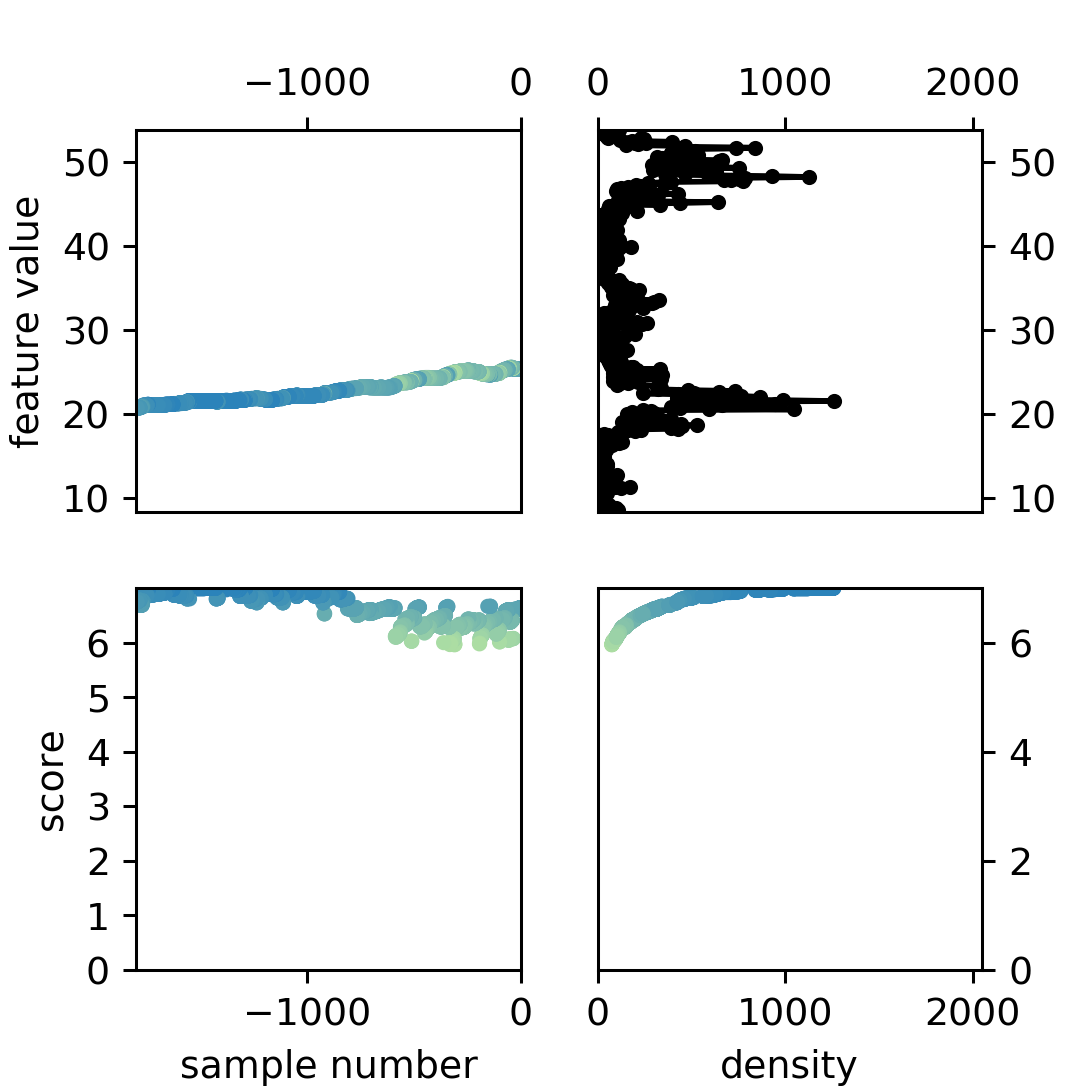

C:\ProgramData\Anaconda3_1\envs\ATK\lib\site-packages\matplotlib\colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [9]:
%matplotlib notebook

import numpy as np

typcheck     = typicalitycheck(MinimumFeasibleValue=-420,MaximumFeasibleValue=+420,Treatment = 'digital')

x = np.empty((0,), dtype=[('DateTime', np.datetime64),\
                                        ('CheckDateTime',np.bool_),\
                                        ('CheckT4b',np.bool_),\
                                        ('Number',np.float_),\
                                        ('ScoreT4b',np.float_),\
                                        ('Density',np.float_)])
dfCheck = pandas.DataFrame(x)

NumberOfSamples = len(dfStrData)
#NumberOfSamples =300
from basic.typical import typicalitydisplay 

typdisp = typicalitydisplay(typcheck,memorylength=1800)
typdisp(typcheck,density=dfCheck['Density'],value=dfCheck['Number'],score=dfCheck['ScoreT4b'])

for iSample in range(NumberOfSamples):
    if numpy.mod(iSample,300)==0:
        typdisp(CheckTYP,plotupdate=True)
        #print('Sample '+str(iSample)+' of '+str(NumberOfSamples))
        pass
        
    strDateTime = dfStrData['date_time'][iSample]
    strT4b      = dfStrData['T4b'][iSample]
    
    ###########################################################
    ### COPY THE CODE BELOW FOR YOUR REAL-TIME APPLICATION  ###
    ###########################################################
    
    CheckResult0 , DateTime = CheckDT(DateTimeEntry=[strDateTime])
    CheckResult1 , Number   = CheckNUM(NumberEntry=[strT4b])
    Score, Density          = CheckTYP(Number)
    ############################################################
    ### COPY THE CODE BELOW FOR YOUR REAL-TIME VISUALIZATION ###
    ############################################################
    
    typdisp(CheckTYP,value=Number,score=Score,density=Density,plotupdate=False)


# Take home message

This example demonstrates the use of the *typicality* module in the AnomalyToolKit software package for the purpose of an online application. We recommend the on-line approach when:

* The typicality of the produced data must be checked immediately upon production, e.g. for use in automated application or online model updating

We do not recommend this approach to:

* Check the typicality of the produced data some time after the data is produced. In this case, check the notebook `AnomalyToolKit_Demo4_BatchMode_Typicality.ipynb` and select one of the approaches demonstrated there.